# Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t,psi, H):
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(psi0, h, H, t = 2, t0 = 0):
    
    S = np.zeros((2,int(100*t)), dtype=np.complex_)
    r = 0

    for i in np.arange(t0, t, 0.01):
        
        S[0][r] = psi0[0][0]
        S[1][r] = psi0[1][0]
        
        k1 = dpsidt(t0, psi0, H)
        k2 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k1)), H)
        k3 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k2)), H)
        k4 = dpsidt(t0 + h, somar(psi0, np.dot(h, k3)), H)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        psi0 = somar(psi0,np.dot((h / 6.0),(C)))
    
        t0 = t0 + h
        
        r = r + 1
    
    P = np.zeros((2,1), dtype=np.complex_)
    P[0][0] = S[0][r-1]
    P[1][0] = S[1][r-1]
    return P

def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H1 = [[0, x[0]], [x[0], 0]]
    
    ## Tamanho do horizonte
    tam = 10
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0
    ajuda = 0.02

    Z = np.zeros((2,1),dtype=np.complex_)
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    Return += (np.linalg.norm(M-Z))**2
    ##print(Return)
    Result = rungeKutta(M, h, somar(H,H1), t = ajuda, t0 = 0)
    M = Result
    
    teste = tam + i
    
    ajuda += 0.01
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    for p in range(i+1, teste):
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*p/100)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*p/100)
        Return += (np.linalg.norm(M-Z))**2
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Result = rungeKutta(M, h, somar(H,H1), t = ajuda, t0 = ajuda-0.01)
        ajuda += 0.01
        M = Result
    
    return Return

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
# Horizonte de análise
tam = 10
i = 0 # Iteração
h = 0.01 # Fator Runge-Kutta

# Proposta dos pontos
x = []
x.append(random.uniform(-1, 1))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp = np.zeros((2, 2000), dtype=np.complex_)
Constantes = np.zeros((2, 2000), dtype=np.complex_)
Pico = np.zeros((2, 2000), dtype=np.complex_)
Min = np.zeros((1,2000), dtype=np.complex_)
Obj = np.zeros((1,2000), dtype=np.complex_)
aly1 = 0
aly2 = 1
Pico[1][i] = complex(0.60,0.0)

while i < 2000:
    print(i)
    
    Resp[0][i] = psi0[0][0]
    Resp[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Constantes[1][i] = psi0[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100)
    
    # Picos
    
    if(i == aly1*(100/(1/2))):
        Pico[0][i] = psi0[0][0]
        aly1=aly1+1
        
    if(i == aly2*(100)):
        Pico[1][i] = psi0[1][0]
        aly2=aly2+2
    
    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='CG')
    
    #print(resultado)
    
    # Função objetivo
    #Min[0][i] = resultado.x[0]
    
    print(f" Conferindo: {fo(resultado.x, D, H, i, psi0)}")
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 0.02, t0 = 0)
    
    psi0[0][0] = psi_t[0][0]
    psi0[1][0] = psi_t[1][0]
    
    H = [[A, 0], [0, B]]
    
    x = []
    for l in range(0, tam):
        x.append(resultado.x[l])
    
    i += 1

0
 Conferindo: 0.19282642627689991
1
 Conferindo: 0.18971659695626936
2
 Conferindo: 0.1852833487349445
3
 Conferindo: 0.18096519956254334
4
 Conferindo: 0.17676366269679591
5
 Conferindo: 0.1726783633479013
6
 Conferindo: 0.16870067151619464
7
 Conferindo: 0.16483144325771634
8
 Conferindo: 0.16107327828680754
9
 Conferindo: 0.15742371958624013
10
 Conferindo: 0.15388365578206395
11
 Conferindo: 0.15044856033780912
12
 Conferindo: 0.1471164505343272
13
 Conferindo: 0.14388751143441825
14
 Conferindo: 0.14075765351733888
15
 Conferindo: 0.13772632017330855
16
 Conferindo: 0.13479037128859428
17
 Conferindo: 0.13194758651961597
18
 Conferindo: 0.12919587253634504
19
 Conferindo: 0.12653287869337532
20
 Conferindo: 0.12395671638547641
21
 Conferindo: 0.12146519802727958
22
 Conferindo: 0.11905617794692162
23
 Conferindo: 0.11672759206440166
24
 Conferindo: 0.11447701215101132
25
 Conferindo: 0.11230235907455122
26
 Conferindo: 0.11020145637440143
27
 Conferindo: 0.10817209425196518
28
 C

 Conferindo: 0.018542135091367727
225
 Conferindo: 0.01868651958701301
226
 Conferindo: 0.01882895887908437
227
 Conferindo: 0.018966989475349676
228
 Conferindo: 0.019101183395061467
229
 Conferindo: 0.019229240184699098
230
 Conferindo: 0.01935176764956837
231
 Conferindo: 0.019467680321800008
232
 Conferindo: 0.01957662544540867
233
 Conferindo: 0.019676083296370633
234
 Conferindo: 0.019767305113727426
235
 Conferindo: 0.0198500511892387
236
 Conferindo: 0.019923011736500428
237
 Conferindo: 0.019986488389725287
238
 Conferindo: 0.020038198774378093
239
 Conferindo: 0.020079947858423836
240
 Conferindo: 0.02011145424780114
241
 Conferindo: 0.020131746221762333
242
 Conferindo: 0.020141018291153796
243
 Conferindo: 0.0201392642696647
244
 Conferindo: 0.020126578650070535
245
 Conferindo: 0.020103056367695077
246
 Conferindo: 0.0200688711683509
247
 Conferindo: 0.020024247028571838
248
 Conferindo: 0.019969470376276693
249
 Conferindo: 0.01990488409711282
250
 Conferindo: 0.019830882

 Conferindo: 0.022559851407180746
443
 Conferindo: 0.02251123328679777
444
 Conferindo: 0.022447702738696083
445
 Conferindo: 0.02237023985654295
446
 Conferindo: 0.022277103791957777
447
 Conferindo: 0.02217054444696795
448
 Conferindo: 0.022051754021327526
449
 Conferindo: 0.021919880559378102
450
 Conferindo: 0.021775239598472624
451
 Conferindo: 0.021617864529380408
452
 Conferindo: 0.02145015837788136
453
 Conferindo: 0.021272937462240113
454
 Conferindo: 0.021085359568514858
455
 Conferindo: 0.020888543196837493
456
 Conferindo: 0.020683876812116357
457
 Conferindo: 0.020472713844317418
458
 Conferindo: 0.020254224442569312
459
 Conferindo: 0.02003093794476818
460
 Conferindo: 0.019803715557208407
461
 Conferindo: 0.019573483140107786
462
 Conferindo: 0.019340424007658206
463
 Conferindo: 0.01910589012936307
464
 Conferindo: 0.0188696963773891
465
 Conferindo: 0.01863452390553423
466
 Conferindo: 0.018400649228953698
467
 Conferindo: 0.018169762362475517
468
 Conferindo: 0.017941

 Conferindo: 0.020176345007435266
661
 Conferindo: 0.01992692924983109
662
 Conferindo: 0.01967569423731287
663
 Conferindo: 0.019423202192801258
664
 Conferindo: 0.019169736954904055
665
 Conferindo: 0.018916304237502346
666
 Conferindo: 0.018664847175284608
667
 Conferindo: 0.018415372511252397
668
 Conferindo: 0.018169839639334877
669
 Conferindo: 0.017928644335540686
670
 Conferindo: 0.017693113152242947
671
 Conferindo: 0.017463390601106875
672
 Conferindo: 0.01724072845929706
673
 Conferindo: 0.017026488550176445
674
 Conferindo: 0.01682188624715502
675
 Conferindo: 0.01662634138559909
676
 Conferindo: 0.01644164229856429
677
 Conferindo: 0.01626843640211358
678
 Conferindo: 0.01610663589457899
679
 Conferindo: 0.01595777380504243
680
 Conferindo: 0.01582244148648855
681
 Conferindo: 0.015700772262296322
682
 Conferindo: 0.015593522118393604
683
 Conferindo: 0.015500634899801375
684
 Conferindo: 0.015423095783047909
685
 Conferindo: 0.01536107776029977
686
 Conferindo: 0.01531446

 Conferindo: 0.016117438897542972
879
 Conferindo: 0.015966389276100397
880
 Conferindo: 0.015828471350512685
881
 Conferindo: 0.015704192473866885
882
 Conferindo: 0.015594528758640756
883
 Conferindo: 0.015499830611973438
884
 Conferindo: 0.015420057106033426
885
 Conferindo: 0.015355876837193649
886
 Conferindo: 0.015307402065630082
887
 Conferindo: 0.01527480034466261
888
 Conferindo: 0.015257914560753745
889
 Conferindo: 0.015257455044459616
890
 Conferindo: 0.015273259768388014
891
 Conferindo: 0.015305061621074652
892
 Conferindo: 0.015352982649045095
893
 Conferindo: 0.015416393629255497
894
 Conferindo: 0.015495131643067508
895
 Conferindo: 0.015588732167841488
896
 Conferindo: 0.01569735166434511
897
 Conferindo: 0.015819834952618524
898
 Conferindo: 0.015956191199292397
899
 Conferindo: 0.016105608839990033
900
 Conferindo: 0.016267813777816414
901
 Conferindo: 0.016442655355673533
902
 Conferindo: 0.01662899276929214
903
 Conferindo: 0.016825685572904855
904
 Conferindo: 0.

 Conferindo: 0.01548876941505707
1095
 Conferindo: 0.015582353077348485
1096
 Conferindo: 0.015690338409380725
1097
 Conferindo: 0.015812526244492257
1098
 Conferindo: 0.01594865647604218
1099
 Conferindo: 0.016097822133904562
1100
 Conferindo: 0.016259849314409477
1101
 Conferindo: 0.016433596861809285
1102
 Conferindo: 0.0166190983543432
1103
 Conferindo: 0.01681671764935576
1104
 Conferindo: 0.017023700340309107
1105
 Conferindo: 0.017240021936150665
1106
 Conferindo: 0.017464303675567273
1107
 Conferindo: 0.01769628865458617
1108
 Conferindo: 0.017934385740147652
1109
 Conferindo: 0.018178314774887242
1110
 Conferindo: 0.01842632798002685
1111
 Conferindo: 0.018678338839213292
1112
 Conferindo: 0.018932852404956086
1113
 Conferindo: 0.019188814079812634
1114
 Conferindo: 0.019445626413539648
1115
 Conferindo: 0.01970100108521648
1116
 Conferindo: 0.019955746298532234
1117
 Conferindo: 0.020208421704888818
1118
 Conferindo: 0.020458335270342666
1119
 Conferindo: 0.020703649855570293

 Conferindo: 0.017464378192461195
1307
 Conferindo: 0.01769621658225689
1308
 Conferindo: 0.01793578817081273
1309
 Conferindo: 0.018179549894758673
1310
 Conferindo: 0.018428061251025394
1311
 Conferindo: 0.018680061820511063
1312
 Conferindo: 0.018934299087217728
1313
 Conferindo: 0.019190496200047324
1314
 Conferindo: 0.019448060486644114
1315
 Conferindo: 0.019704695012949122
1316
 Conferindo: 0.019959660752400236
1317
 Conferindo: 0.020211537556781754
1318
 Conferindo: 0.02046065550615539
1319
 Conferindo: 0.020705872732854003
1320
 Conferindo: 0.020945910055189344
1321
 Conferindo: 0.02117960644000843
1322
 Conferindo: 0.02140528020997931
1323
 Conferindo: 0.02162293140384727
1324
 Conferindo: 0.02183062225949069
1325
 Conferindo: 0.022028546386987192
1326
 Conferindo: 0.02221684403668063
1327
 Conferindo: 0.022392612717756742
1328
 Conferindo: 0.022556392177804092
1329
 Conferindo: 0.022708019011603412
1330
 Conferindo: 0.02284670753315758
1331
 Conferindo: 0.022970190639161968


 Conferindo: 0.02070422243264759
1520
 Conferindo: 0.02094331394197875
1521
 Conferindo: 0.021176414204025735
1522
 Conferindo: 0.021403017803813852
1523
 Conferindo: 0.02162048760474078
1524
 Conferindo: 0.02182801201659624
1525
 Conferindo: 0.02202624312744351
1526
 Conferindo: 0.02221480644445737
1527
 Conferindo: 0.022391472734573425
1528
 Conferindo: 0.02255498861470368
1529
 Conferindo: 0.022706150179661648
1530
 Conferindo: 0.02284605110817453
1531
 Conferindo: 0.022971094652833274
1532
 Conferindo: 0.023080671755338587
1533
 Conferindo: 0.02317573335401981
1534
 Conferindo: 0.023256331158929486
1535
 Conferindo: 0.02332002376395513
1536
 Conferindo: 0.023368764032418388
1537
 Conferindo: 0.023402985119330238
1538
 Conferindo: 0.023420085412816708
1539
 Conferindo: 0.02342027621530127
1540
 Conferindo: 0.023405045609436737
1541
 Conferindo: 0.023375162348849322
1542
 Conferindo: 0.023328163320902595
1543
 Conferindo: 0.023264338251772845
1544
 Conferindo: 0.023185402865284033
15

 Conferindo: 0.022971073487238834
1732
 Conferindo: 0.02308289164853539
1733
 Conferindo: 0.02317871842891661
1734
 Conferindo: 0.023258003528108785
1735
 Conferindo: 0.023322603618758313
1736
 Conferindo: 0.023372701826386833
1737
 Conferindo: 0.023406109538993164
1738
 Conferindo: 0.023421942639146653
1739
 Conferindo: 0.023423086686509553
1740
 Conferindo: 0.02340778454142404
1741
 Conferindo: 0.023376163756998428
1742
 Conferindo: 0.023330578314519273
1743
 Conferindo: 0.023268145545224217
1744
 Conferindo: 0.02318886336983433
1745
 Conferindo: 0.023094828954013907
1746
 Conferindo: 0.02298658332081675
1747
 Conferindo: 0.022863311974119217
1748
 Conferindo: 0.022725805745481345
1749
 Conferindo: 0.02257481805640765
1750
 Conferindo: 0.022411649545817862
1751
 Conferindo: 0.02223627838561136
1752
 Conferindo: 0.022050092649812923
1753
 Conferindo: 0.021851997520922477
1754
 Conferindo: 0.02164463582915055
1755
 Conferindo: 0.02142922519506755
1756
 Conferindo: 0.021204696238538143


 Conferindo: 0.023272445588710028
1944
 Conferindo: 0.023194304806617723
1945
 Conferindo: 0.023100412666771153
1946
 Conferindo: 0.022990861652157378
1947
 Conferindo: 0.02286743836566954
1948
 Conferindo: 0.02273217922764289
1949
 Conferindo: 0.022582458229523865
1950
 Conferindo: 0.022418235500909142
1951
 Conferindo: 0.022242332187547884
1952
 Conferindo: 0.022056654784547464
1953
 Conferindo: 0.021859548327431724
1954
 Conferindo: 0.02165321013818982
1955
 Conferindo: 0.021436775709108027
1956
 Conferindo: 0.021211332364543527
1957
 Conferindo: 0.020979139920055487
1958
 Conferindo: 0.02074129913390466
1959
 Conferindo: 0.02049717548013994
1960
 Conferindo: 0.020248244130003926
1961
 Conferindo: 0.01999632141416546
1962
 Conferindo: 0.019741107951492875
1963
 Conferindo: 0.019484998481946295
1964
 Conferindo: 0.019228062879194797
1965
 Conferindo: 0.018972030001088346
1966
 Conferindo: 0.018717482699407546
1967
 Conferindo: 0.018465432828794967
1968
 Conferindo: 0.0182159414172269

## Gráficos - Avaliação da defasagem

Conforme o livro, introdução à computação quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

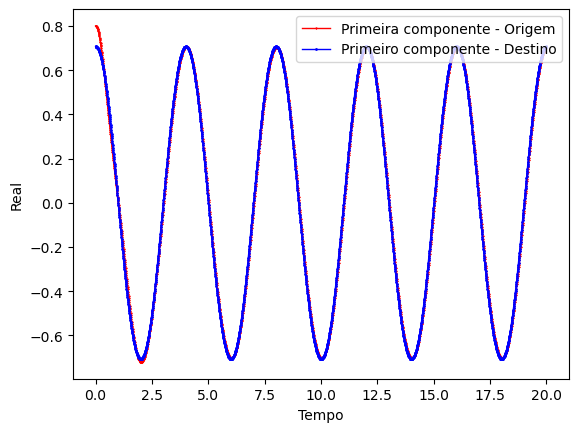

In [4]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[0]] 
ImagO = [ele.imag for ele in Resp[0]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

sub = []
for i in range(0, 2000):
    sub.append((abs(Resp[0][i]) - abs(sup[i])))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente - Origem")
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1, label="Primeiro componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo1.png', format='png')
plt.show()

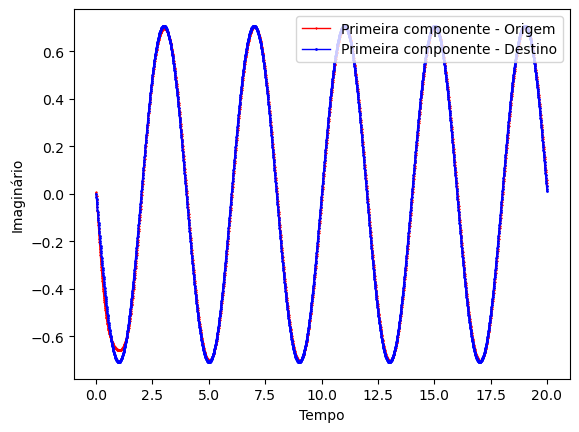

In [5]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente - Origem")
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1, label="Primeira componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo2.png', format='png')
plt.show()

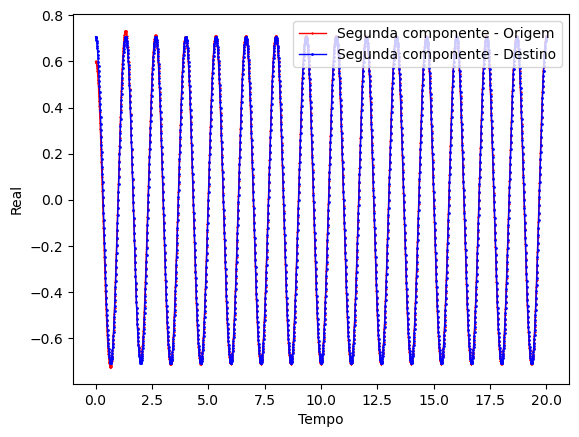

In [6]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[1]] 
ImagO = [ele.imag for ele in Resp[1]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

subr = []
for i in range(0, 2000):
    subr.append((abs(Resp[1][i]) - abs(sup[i])))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1, label="Segunda componente - Origem")
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo3.png', format='png')
plt.show()

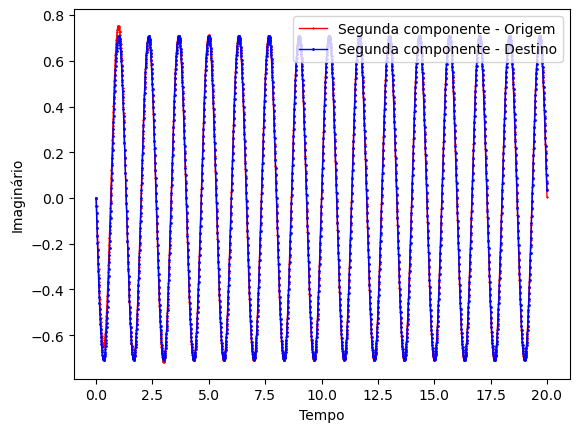

In [7]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1, label="Segunda componente - Origem")
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo4.png', format='png')
plt.show()

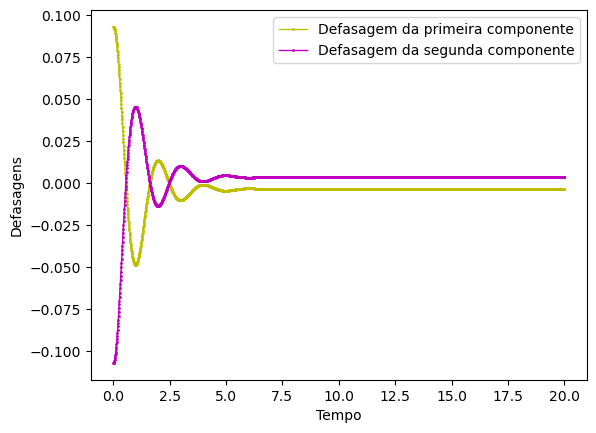

In [8]:
plt.ylabel('Defasagens') 
plt.xlabel('Tempo') 
plt.plot(ts, sub, color='y', marker='o',  linewidth=1, markersize=1, label="Defasagem da primeira componente")
plt.plot(ts, subr, color='m', marker='o',  linewidth=1, markersize=1, label="Defasagem da segunda componente")
plt.legend(loc="upper right")
plt.savefig('phases.png', format='png')
plt.show()

#### Valor da defasagem

In [9]:
print(subr[999])

0.0035691421533851075


Mesma defasagem em ambas as componentes representa uma defasagem global idêntica que pode ser desprezada.

## Gráficos - Avaliação das constantes da função de onda

Outra interpretação pertinente é a obtenção das constantes de onda, pois o objetivo inicial da pesquisa é sair de uma constante e chegar em um estado de forma que estas estajam em total equilíbrio. Para realizar a plotagem com os diversos números complexos se faz o uso do número absoluto que para o estudo do conjunto complexo representa o seu tamanho, dessa forma, é possível indentificar se o estado inicial alcançou o final desejado.

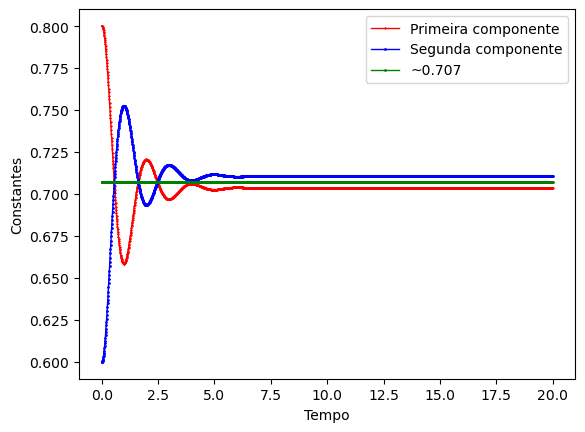

In [10]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(Constantes[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.savefig('const.png', format='png')
plt.show()

## Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

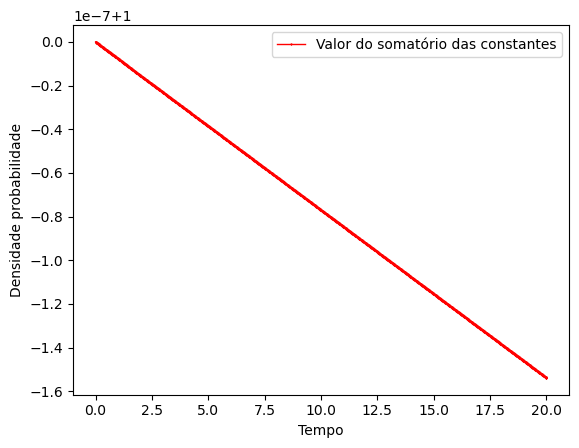

In [11]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(Constantes[0][i])**2+abs(Constantes[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()

## Organização e gráfico da função objetivo

Nessa etapa do trabalho se torna importante verificar como a função objetivo está se comportando durante o projeto. Além disso, nessa seção, organiza-se algumas informações relevantes acerca do trabalho.

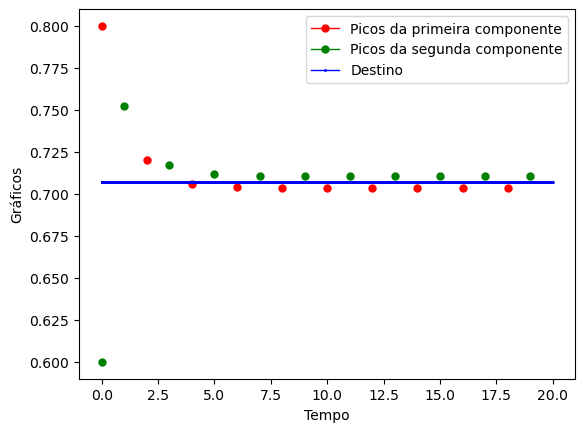

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

teste = np.zeros((2, 2000), dtype=np.complex_)
for i in range(0, 2000):
    teste[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    
def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, zero_to_nan(abs(Pico[0])), color='r', marker='o', linewidth=1, markersize=5, label="Picos da primeira componente")
plt.plot(ts, zero_to_nan(abs(Pico[1])), color='g', marker='o', linewidth=1, markersize=5, label="Picos da segunda componente")
plt.plot(ts, abs(teste[0]), color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc="upper right")
plt.savefig('pico.png', format='png')
plt.show()

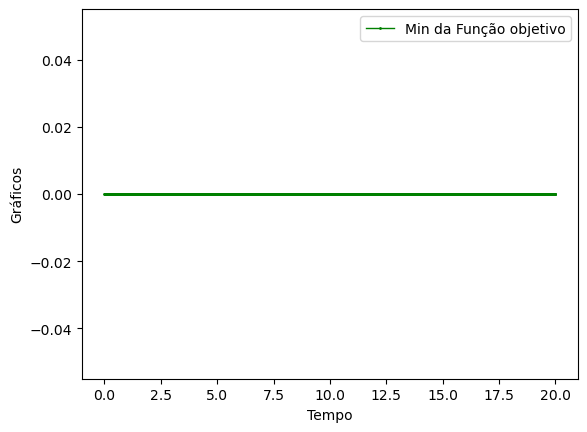

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min[0]), color='g', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo")
plt.legend(loc="upper right")
plt.savefig('min.png', format='png')
plt.show()

## Aumento do horizonte

É notável que a função objetivo não alcançou totalmente o zero e a justificativa para tal resultado pode estar no horizonte escolhido para a análise. Por mais que possamos aumentar o horizonte vale ressaltar que o seu aumento tem um custo computacional exponencial.

#### Aumento para 6

In [14]:
def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H1 = [[0, x[0]], [x[0], 0]]
    
    ## Tamanho do horizonte
    tam = 6
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0

    Z = np.zeros((2,1),dtype=np.complex_)
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    Return += (np.linalg.norm(M-Z))**2
    Result = rungeKutta(M, h, somar(H,H1), t = 2/100, t0 = 0)
    M = Result
    
    teste = tam + i
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    for p in range(i+1, teste):
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*p/100)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*p/100)
        Return += (np.linalg.norm(M-Z))**2
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Result = rungeKutta(M, h, somar(H,H1), t = ((p-i)+2)/100, t0 = ((p-i)/100))
        M = Result
    
    return Return

In [15]:
# Horizonte de análise
tam = 6
i = 0 # Iteração
h = 0.01 # Fator Runge-Kutta

# Proposta dos pontos
x = []
x.append(random.uniform(-1, 1))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp_h = np.zeros((2, 2000), dtype=np.complex_)
Constantes_h = np.zeros((2, 2000), dtype=np.complex_)
Pico_h = np.zeros((2, 2000), dtype=np.complex_)
Min_h = np.zeros((1,2000), dtype=np.complex_)
Obj_h = np.zeros((1,2000), dtype=np.complex_)
aly1 = 0
aly2 = 1
Pico_h[1][i] = complex(0.60,0.0)

while i < 2000:
    
    Resp_h[0][i] = psi0[0][0]
    Resp_h[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes_h[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Constantes_h[1][i] = psi0[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100)
    
    # Picos
    
    if(i == aly1*(100/(1/2))):
        Pico_h[0][i] = psi0[0][0]
        aly1=aly1+1
        
    if(i == aly2*(100)):
        Pico_h[1][i] = psi0[1][0]
        aly2=aly2+2
    
    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='CG')
    
    print(resultado)
    
    # Função objetivo
    Min_h[0][i] = resultado.x[0]
    
    Obj_h[0][i] = fo(resultado.x, D, H, i, psi0)
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    x = []
    for l in range(0, tam):
        x.append(resultado.x[l])

    i += 1

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.12189999824414932
       x: [-1.570e+00  8.647e-01  4.595e-01 -1.004e+00  1.388e+00
           -7.398e-01]
     nit: 9
     jac: [-5.281e-06 -5.759e-06 -3.949e-07  1.237e-06  2.995e-06
            0.000e+00]
    nfev: 399
    njev: 57


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes_h[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(Constantes_h[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.savefig('const_h.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

teste = np.zeros((2, 2000), dtype=np.complex_)
for i in range(0, 2000):
    teste[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    
def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, zero_to_nan(abs(Pico_h[0])), color='r', marker='o', linewidth=1, markersize=5, label="Picos da primeira componente")
plt.plot(ts, zero_to_nan(abs(Pico_h[1])), color='g', marker='o', linewidth=1, markersize=5, label="Picos da segunda componente")
plt.plot(ts, abs(teste[0]), color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc="upper right")
plt.savefig('pico_h.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min_h[0]), color='g', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo")
plt.legend(loc="upper right")
plt.savefig('min_h.png', format='png')
plt.show()

In [ ]:
# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes[0]), color='g', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(Constantes[1]), color='y', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, abs(Constantes_h[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente - Horizonte")
plt.plot(ts, abs(Constantes_h[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente - Horizonte")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.savefig('comparacoes.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min[0]), color='g', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo")
plt.plot(ts, abs(Min_h[0]), color='r', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo - Horizonte")
plt.legend(loc="upper right")
plt.savefig('min_comparacoes.png', format='png')
plt.show()

#### Aumento para 8

In [ ]:
def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H1 = [[0, x[0]], [x[0], 0]]
    
    ## Tamanho do horizonte
    tam = 8
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0

    Z = np.zeros((2,1),dtype=np.complex_)
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    Return += (np.linalg.norm(M-Z))**2
    Result = rungeKutta(M, h, somar(H,H1), t = 2/100, t0 = 0)
    M = Result
    
    teste = tam + i
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    for p in range(i+1, teste):
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*p/100)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*p/100)
        Return += (np.linalg.norm(M-Z))**2
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Result = rungeKutta(M, h, somar(H,H1), t = ((p-i)+2)/100, t0 = (p-i)/100)
        M = Result
    
    return Return

In [ ]:
# Horizonte de análise
tam = 8
i = 0 # Iteração
h = 0.01 # Fator Runge-Kutta

# Proposta dos pontos
x = []
x.append(random.uniform(-1, 1))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp_h2 = np.zeros((2, 2000), dtype=np.complex_)
Constantes_h2 = np.zeros((2, 2000), dtype=np.complex_)
Pico_h2 = np.zeros((2, 2000), dtype=np.complex_)
Obj_h2 = np.zeros((1,2000), dtype=np.complex_)
Min_h2 = np.zeros((1,2000), dtype=np.complex_)
aly1 = 0
aly2 = 1
Pico_h2[1][i] = complex(0.60,0.0)

while i < 2000:
    
    Resp_h2[0][i] = psi0[0][0]
    Resp_h2[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes_h2[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Constantes_h2[1][i] = psi0[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100)
    
    # Picos
    
    if(i == aly1*(100/(1/2))):
        Pico_h2[0][i] = psi0[0][0]
        aly1=aly1+1
        
    if(i == aly2*(100)):
        Pico_h2[1][i] = psi0[1][0]
        aly2=aly2+2
    
    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='CG')
    
    print(resultado)
    
    # Função objetivo
    Min_h2[0][i] = resultado.x[0]
    
    Obj_h2[0][i] = fo(resultado.x, D, H, i, psi0)
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    x = []
    for l in range(0, tam):
        x.append(resultado.x[l])

    i += 1

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min[0]), color='g', marker='o', linewidth=1, markersize=1, label="Mínimo da Função objetivo")
plt.plot(ts, abs(Min_h[0]), color='r', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo - Horizonte")
plt.plot(ts, abs(Min_h2[0]), color='y', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo - Amplificado")
plt.legend(loc="upper right")
plt.savefig('min_comparacoes1.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Obj[0]), color='g', marker='o', linewidth=1, markersize=1, label="Função objetivo")
plt.plot(ts, abs(Obj_h[0]), color='r', marker='o', linewidth=1, markersize=1, label="Função objetivo - Horizonte")
plt.plot(ts, abs(Obj_h2[0]), color='y', marker='o', linewidth=1, markersize=1, label="Função objetivo - Amplificado")
plt.legend(loc="upper right")
plt.savefig('obj_comparacoes.png', format='png')
plt.show()